In [33]:
%matplotlib widget
import os
import math

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [34]:
dataPath = "data/videos/2016_0718_200947_002"  # input video path
cornerDataPath = "data/corners.npy"
calibrationDataPath = "data/calibration.xml"
readExistingCornerData = False

patternSize = (8, 6)  # number of corners in the calibration pattern (rows, columns)
subPixWinSize = (5, 5)  # depends on the resolution, 5, 5 seems ok for this camera resolution

maxNumSamples = 40  # if there are more than this collected samples, all samples are shuffled and subsampled
skipFrames = 120 # how many frames do we skip while seeking video for calibration shots
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


In [35]:
# read sample video for out frame size
framePaths = list(map(lambda f: os.path.join(dataPath, f), filter(lambda f: ".png" in f, os.listdir(dataPath))))

frames = list(map(lambda f: cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2GRAY), framePaths))

print("Read {} frames".format(len(frames)))

Read 274 frames


In [36]:
validFrames = []

allCorners = []  # collection of all corners for calibration purposes
if not readExistingCornerData:

    # Enable interactive mode
    for frame in tqdm(frames):
        quitReading = False

        # try detecting the chart
        patternWasFound, corners = cv2.findChessboardCorners(frame, patternSize, cv2.CALIB_CB_FAST_CHECK)

        if patternWasFound:
            corners = cv2.cornerSubPix(frame, corners, subPixWinSize, (-1, -1), criteria)
            allCorners.append(corners)
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            cv2.drawChessboardCorners(frame_bgr, patternSize, corners, patternWasFound)

            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            validFrames.append(frame)

    allCorners = np.array(allCorners)
    np.save(cornerDataPath, allCorners)

    print("Saved corners to {}".format(cornerDataPath))
else:
    allCorners = np.load(cornerDataPath)

numSamples = allCorners.shape[0]
print("Collected {} corner sampels.".format(numSamples))

  0%|          | 0/274 [00:00<?, ?it/s]

Saved corners to data/corners.npy
Collected 151 corner sampels.


In [11]:
# take just number of samples
if numSamples > maxNumSamples:
    # np.random.shuffle(sampleIds)

    ratio = int(math.ceil(numSamples / maxNumSamples))
    print("ratio: {}".format(ratio))

    sampleIds = np.arange(0, numSamples, ratio)

    allCorners = allCorners[sampleIds]
    numSamples = allCorners.shape[0]

    print("Num samples trimmed to {}, according to selection:\n{}".format(numSamples, sampleIds))


In [37]:
# setting up object points
patternSquareSideLength = 1.6
objPoints = np.zeros((patternSize[0]*patternSize[1], 3), np.float32)
objPoints[:, :2] = np.mgrid[0:patternSize[0], 0:patternSize[1]].T.reshape(-1, 2).astype(np.float32)
objPoints *= patternSquareSideLength

# Assuming `objPoints` is a list of lists or a list of arrays
# First, convert it to a numpy array
objPoints = np.array([objPoints] * numSamples)

objPoints = np.reshape(objPoints, (numSamples, objPoints[0].shape[0], 1, 3))

# Then, convert it to a 3-channel float32 array if it's not already
if objPoints.dtype != np.float32 or objPoints.shape[-1] != 3:
    objPoints = objPoints.astype(np.float32)


In [54]:
frameSize = validFrames[0].shape[::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, allCorners, frameSize, None, None)

if ret:
    print("Matrix:\n{}".format(mtx))
    print("Distortion:\n{}".format(dist))

    storage = cv2.FileStorage(calibrationDataPath, cv2.FILE_STORAGE_WRITE)
    storage.write("mtx", mtx)
    storage.write("dist", dist)
    storage.release()

    # print(rvecs)
    # print(tvecs)
else:
    print("Calibration failed")
    sys.exit(1)

# find optimal camera matrix
h, w = frame.shape[0:2]

Matrix:
[[692.4987275    0.         623.82772967]
 [  0.         702.21752164 351.10537077]
 [  0.           0.           1.        ]]
Distortion:
[[-0.32179997  0.1486121   0.00187194 -0.00581076 -0.04158308]]


In [56]:
# Assuming you have an image stored in the variable `img`
img = validFrames[0]

h, w = img.shape[:2]

dist_scale = 0.1

# Compute the undistortion and rectification transformation map
undistorted_img = cv2.undistort(img, mtx, dist)


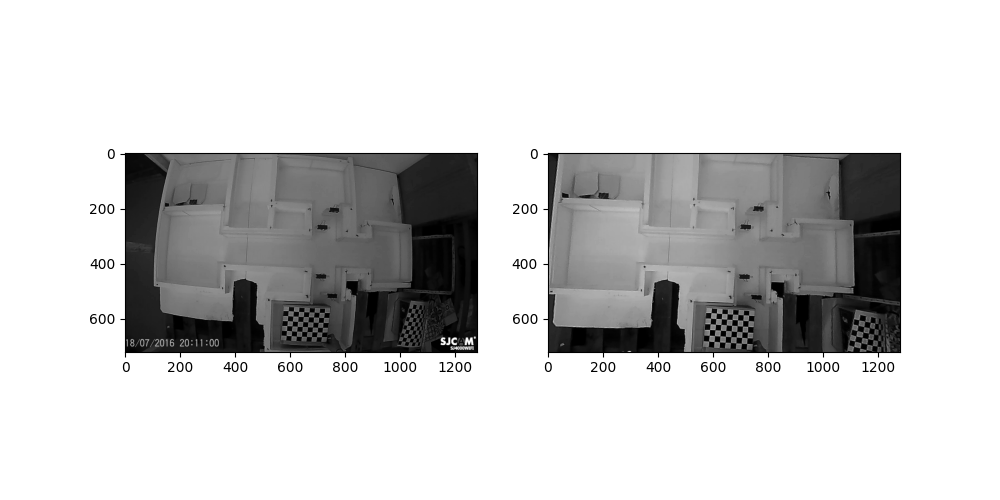

In [57]:
# show undistorted image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(validFrames[0], cmap="gray")
ax[1].imshow(undistorted_img, cmap="gray")

plt.show()